In [1]:
import sys
sys.path.append('/home/devyhia/LendingAHand/')
sys.path.append('/home/deeplearners/caffe/python/')

import numpy as np
#import Image
import sys
import os
import PIL
import operator
from  math import pow
from PIL import Image, ImageDraw, ImageFont
import caffe

caffe.set_device(0)

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sys.path.append('/home/devyhia/FaceDetection_CNN/')
from nms import nms

In [4]:
from scipy.ndimage import imread

In [5]:
caffe_root = '/home/deeplearners/caffe/'

In [6]:
net_full_conv = caffe.Net(
    '/home/devyhia/LendingAHand/hand_classifier_conv.prototxt',
    '/home/devyhia/LendingAHand/hand_classifier_conv.caffemodel',
    caffe.TEST
)

In [54]:
net_full = caffe.Net(
    '/home/devyhia/LendingAHand/hand_classifier.prototxt',
    '/home/devyhia/LendingAHand/hand_classifier.caffemodel',
    caffe.TEST
)

In [13]:
def generateBoundingBox(featureMap, scale):
    boundingBox = []
    stride = 32
    cellSize = 227
    #227 x 227 cell, stride=32
    for (x,y), prob in np.ndenumerate(featureMap):
        if(prob >= 0.1):
            boundingBox.append([float(stride * y)/ scale, float(x * stride)/scale, float(stride * y + cellSize - 1)/scale, float(stride * x + cellSize - 1)/scale, prob])
    #sort by prob, from max to min.
    #boxes = np.array(boundingBox)
    return boundingBox

In [55]:
net_full_conv.blobs

OrderedDict([('data', <caffe._caffe.Blob at 0x7f774fed3848>),
             ('conv1', <caffe._caffe.Blob at 0x7f774fed35f0>),
             ('pool1', <caffe._caffe.Blob at 0x7f774fed39b0>),
             ('norm1', <caffe._caffe.Blob at 0x7f774fed3a28>),
             ('conv2', <caffe._caffe.Blob at 0x7f774fed3b90>),
             ('pool2', <caffe._caffe.Blob at 0x7f774fed3758>),
             ('norm2', <caffe._caffe.Blob at 0x7f774fed3938>),
             ('conv3', <caffe._caffe.Blob at 0x7f774fed3aa0>),
             ('conv4', <caffe._caffe.Blob at 0x7f774fed3de8>),
             ('conv5', <caffe._caffe.Blob at 0x7f774fed3b18>),
             ('pool5', <caffe._caffe.Blob at 0x7f774fed3d70>),
             ('fc6-conv', <caffe._caffe.Blob at 0x7f774fed3cf8>),
             ('fc7-conv', <caffe._caffe.Blob at 0x7f774fed3c80>),
             ('fc8-conv', <caffe._caffe.Blob at 0x7f774f2ce758>),
             ('prob', <caffe._caffe.Blob at 0x7f774f2ce938>)])

In [86]:
!wget http://a.scpr.org/i/0fb039f9119d1310ee112897996da0a9/133472-full.jpg

--2017-04-22 23:24:23--  http://a.scpr.org/i/0fb039f9119d1310ee112897996da0a9/133472-full.jpg
Resolving a.scpr.org (a.scpr.org)... 205.144.168.165
Connecting to a.scpr.org (a.scpr.org)|205.144.168.165|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘133472-full.jpg.1’

133472-full.jpg.1       [      <=>           ] 221.40K   214KB/s    in 1.0s    

2017-04-22 23:24:25 (214 KB/s) - ‘133472-full.jpg.1’ saved [226710]



In [ ]:
glob

In [47]:
Image.open('/home/devyhia/hand_dataset_indiana/train/pos/5L_0038145_I_3_0_3.png').size

(960, 544)

In [84]:
!ls *.jpg

133472-full.jpg				       testDriver.jpg
396463-tlsnewslandscape.jpg		       texting.jpg.jpg
Faces-of-the-Future-1.jpg		       tmp.jpg
HumanHeadphonesHP-1200x630-e1474323336782.jpg


In [9]:
img_url = '/home/devyhia/distracted.driver/Talk Left/600.original.jpg'

In [10]:
img = Image.open(img_url)

In [58]:
img_arr = imread(img_url)

In [11]:
scales = [1, 0.793700526, 0.6299605249726766, 0.5000000000300495, 0.3968502630238503, 0.31498026250526834, 0.2500000000300495]

In [55]:
total_boxes = []
for scale in scales[1:2]:
    print("Image: {} - Scale: {}".format(0, scale))
    
    scale_img = img.resize((int(img.size[0] * scale), int(img.size[1] * scale)))
    scale_img.save("tmp.jpg")
    
    net_full_conv.blobs['data'].reshape(1,3,scale_img.size[1], scale_img.size[0])
    
    im = caffe.io.load_image("tmp.jpg")
    transformer = caffe.io.Transformer({'data': net_full_conv.blobs['data'].data.shape})
    transformer.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1))
    transformer.set_transpose('data', (2,0,1))
    transformer.set_channel_swap('data', (2,1,0))
    transformer.set_raw_scale('data', 255.0)
    
    out = net_full_conv.forward_all(data=np.asarray([transformer.preprocess('data', im)]))
    
    boxes = generateBoundingBox(out['prob'][0,1], scale)
    
    if(boxes):
        total_boxes.extend(boxes)

Image: 0 - Scale: 1


In [56]:
len(total_boxes)

219

In [57]:
print('NMS - MAX')
#nms
boxes_nms = np.array(total_boxes)
# true_boxes1 = boxes_nms
# true_boxes1 = nms_max(boxes_nms, overlapThresh=0.3)
# Shared.update_screen('NMS - AVG - Boxes: {}\n'.format(true_boxes1.shape[0]))
# true_boxes = nms_average(np.array(true_boxes1), overlapThresh=0.07)
# true_boxes = non_max_suppression_fast(true_boxes1, overlapThresh=0.07)
# Shared.update_screen('{}\n'.format(true_boxes1.shape))
# np.sort(true_boxes1.reshape(-1, 1,1,1,1,1), axis=4)[::-1][:1].reshape(-1,5)
true_boxes = nms(total_boxes, 0.3)

NMS - MAX
Overlap is 0.577092511013
Overlap is 0.132449688525
Overlap is 0.110714355023
Overlap is 0.128723631353
Overlap is 0.495740262765
Overlap is 0.51561256768
Overlap is 0.251683518019
Overlap is 0.495740262765
Overlap is 0.132449688525
Overlap is 0.414388014516
Overlap is 0.495740262765
Overlap is 0.51561256768
Overlap is 0.495740262765
Overlap is 0.110714355023
Overlap is 0.132449688525
Overlap is 0.0455083545188
Overlap is 0.251683518019
Overlap is 0.00390071610161
Overlap is 0.251683518019
Overlap is 0.374643404685
Overlap is 0.414388014516
Overlap is 0.333035766268
Overlap is 0.17033126977
Overlap is 0.616837120845
Overlap is 0.17033126977
Overlap is 0.087115992936
Overlap is 0.414388014516
Overlap is 0.616837120845
Overlap is 0.132449688525
Overlap is 0.616837120845
Overlap is 0.0076267732733
Overlap is 0.0889790215219
Overlap is 0.251683518019
Overlap is 0.295154185022
Overlap is 0.616837120845
Overlap is 0.110714355023
Overlap is 0.17033126977
Overlap is 0.616837120845
Ov

In [58]:
len(true_boxes)

18

In [161]:
out['prob'].shape

(1, 2, 11, 24)

In [120]:
true_boxes

[[576.0, 160.0, 802.0, 386.0, 0.98837155],
 [1184.0, 512.0, 1410.0, 738.0, 0.91999638],
 [1120.0, 160.0, 1346.0, 386.0, 0.81729394],
 [403.1747359340522,
  564.444630307673,
  972.659050440901,
  1133.9289448145219,
  0.75420254]]

In [353]:
sorted([b for b in true_boxes if b[0] >= 0.5 * 1920], reverse=True, key=lambda x: x[4])

[[831.9999999499976, 0.0, 1283.9999999228328, 451.9999999728352, 0.8789745],
 [0.0, 127.99999998461465, 903.999999891341, 1031.9999998759556, 0.87339538],
 [1344.0, 128.0, 1570.0, 354.0, 0.84946847]]

In [84]:
img.size

(1920, 1080)

In [61]:
img = Image.open(img_url)
draw = ImageDraw.Draw(img)
# sorted(true_boxes, reverse=True, key=lambda x: x[4])[:2]
# sorted([b for b in true_boxes if b[2] < 1920 and b[3] < 1080], reverse=True, key=lambda x: x[4])[:2]
for box in sorted([b for b in true_boxes if b[0] >= 0.5 * 1920], reverse=True, key=lambda x: x[4])[:2]:
    draw.rectangle((box[0], box[1], box[2], box[3]), outline=(255,0,0) )
    font_path=os.environ.get("FONT_PATH", "/usr/share/fonts/truetype/dejavu/DejaVuSerif.ttf")
    ttFont = ImageFont.truetype(font_path, 20)
    draw.text((box[0], box[1]), "{0:.2f}".format(box[4]), font=ttFont, fill='red')

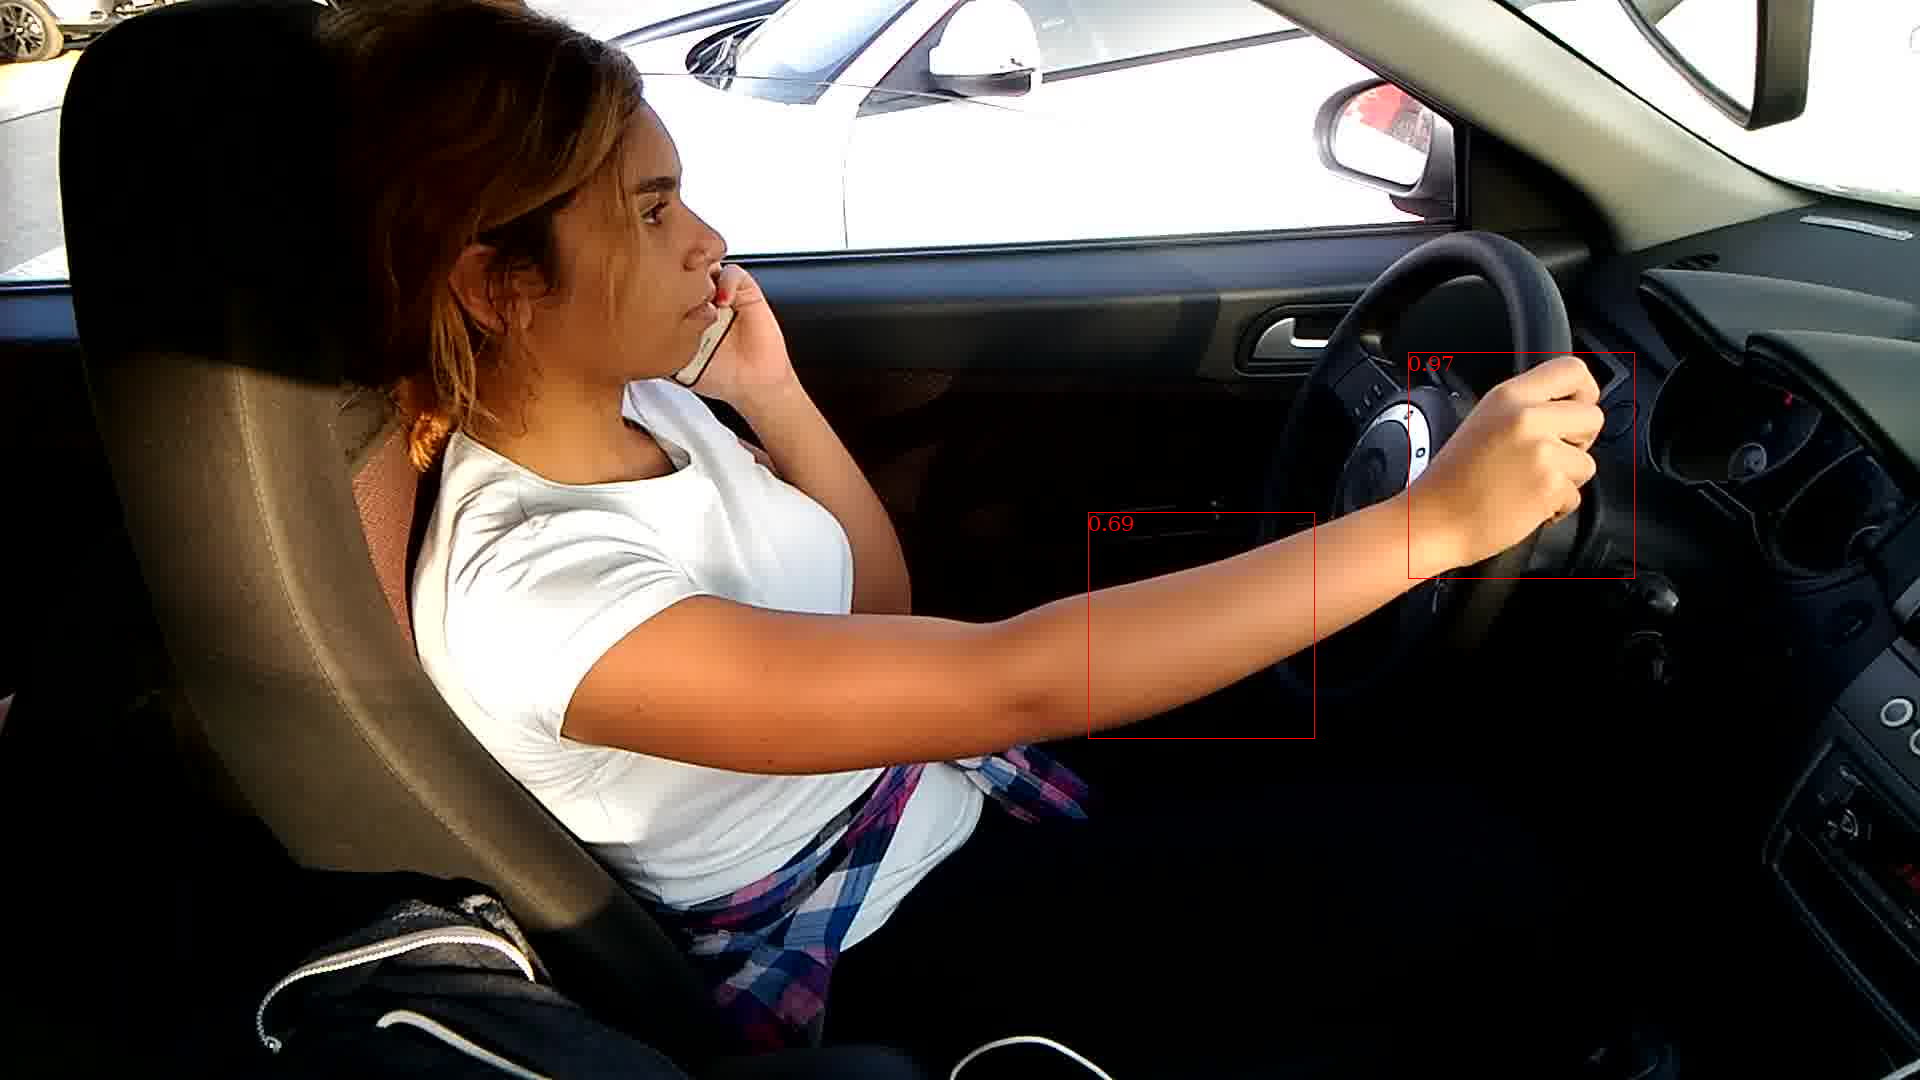

In [62]:
img.resize((int(img.size[0]), int(img.size[1])))

In [324]:
def get_box_probs(boxes):
    for i, box in enumerate(boxes):
        print("{} out of {}".format(i+1, len(boxes)))
        img.crop(map(int, box[:4])).resize((227, 227)).save('tmp.jpg')
    
        transformer = caffe.io.Transformer({'data': net_full.blobs['data'].data.shape})
        transformer.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1))
        transformer.set_transpose('data', (2,0,1))
        transformer.set_channel_swap('data', (2,1,0))
        transformer.set_raw_scale('data', 255.0)

        im = caffe.io.load_image("tmp.jpg")
        out = net_full.forward_all(data=np.asarray([transformer.preprocess('data', im)]))
        box += (out['prob'][0][1],) # probability it is a hand

In [368]:
get_box_probs(true_boxes)

1 out of 7
2 out of 7
3 out of 7
4 out of 7
5 out of 7
6 out of 7
7 out of 7


In [292]:
true_boxes

[[1056.0, 608.0, 1282.0, 834.0, 0.99049205, 0.97150964],
 [480.0, 224.0, 706.0, 450.0, 0.97795838, 0.97457379],
 [1248.0, 224.0, 1474.0, 450.0, 0.85414159, 0.70037168],
 [96.0, 160.0, 322.0, 386.0, 0.22373913, 0.029323393]]

In [370]:
img = Image.open(img_url)
draw = ImageDraw.Draw(img)
# sorted(true_boxes, reverse=True, key=lambda x: x[4])[:2]
# sorted([b for b in true_boxes if b[2] < 1920 and b[3] < 1080], reverse=True, key=lambda x: x[4])[:2]
for box in sorted([b for b in true_boxes if b[0] >= 0.25 * 1920], reverse=True, key=lambda x: x[5]):
    draw.rectangle((box[0], box[1], box[2], box[3]), outline=(255,0,0) )
    font_path=os.environ.get("FONT_PATH", "/usr/share/fonts/truetype/dejavu/DejaVuSerif.ttf")
    ttFont = ImageFont.truetype(font_path, 20)
    draw.text((box[0], box[1]), "{0:.2f}".format(box[5]), font=ttFont, fill='red')

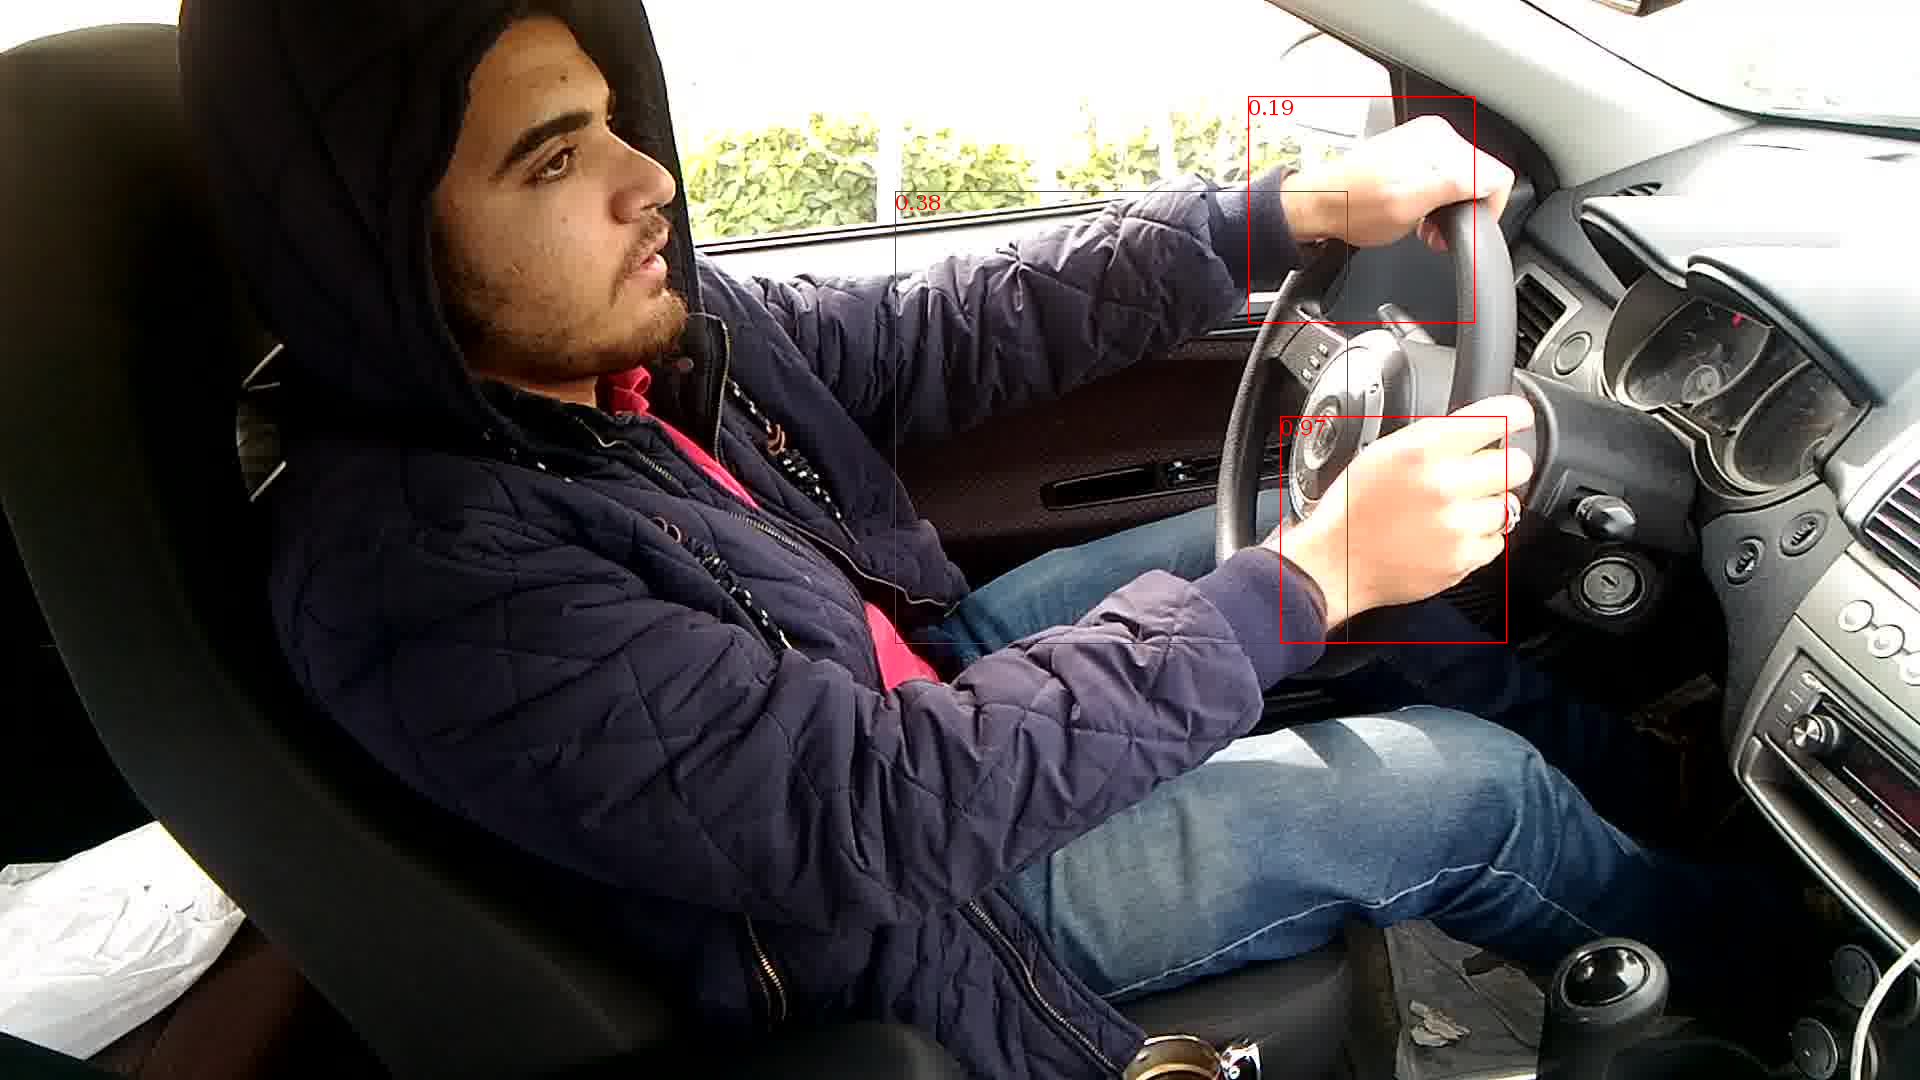

In [371]:
img

In [261]:
boxes_nms = np.array(boxes)

In [262]:
true_boxes = nms(boxes, 0.1)

Overlap is 0.0237730210173
Overlap is 0.00203768751577
Overlap is 0.00390071610161
Overlap is 0.0455083545188
Overlap is 0.0455083545188
Overlap is 0.00390071610161
Overlap is 0.0889790215219
Overlap is 0.0672436880203
Overlap is 0.087115992936
Overlap is 0.00576374468746
Overlap is 0.110714355023
Overlap is 0.0672436880203
Overlap is 0.211938908188
Overlap is 0.253546546605
Overlap is 0.128723631353
Overlap is 0.00576374468746
Overlap is 0.17033126977
Overlap is 0.132449688525
Overlap is 0.0076267732733
Overlap is 0.128723631353
Overlap is 0.295154185022
Overlap is 0.0076267732733
Overlap is 0.0132158590308
Overlap is 0.154185022026
Overlap is 0.313163461352
Overlap is 0.154185022026
Overlap is 0.00948980185915
Overlap is 0.011352830445
Overlap is 0.011352830445
Overlap is 0.190203574686
Overlap is 0.0889790215219
Overlap is 0.251683518019
Overlap is 0.295154185022
Overlap is 0.374643404685
Overlap is 0.132449688525
Overlap is 0.110714355023
Overlap is 0.00390071610161
Overlap is 0.25

In [263]:
len(true_boxes)

8

In [265]:
draw = ImageDraw.Draw(img)
for box in true_boxes:
    draw.rectangle((box[0], box[1], box[2], box[3]), outline=(255,0,0) )
    font_path=os.environ.get("FONT_PATH", "/usr/share/fonts/truetype/dejavu/DejaVuSerif.ttf")
    ttFont = ImageFont.truetype(font_path, 20)
    draw.text((box[0], box[1]), "{0:.2f}".format(box[4]), font=ttFont)

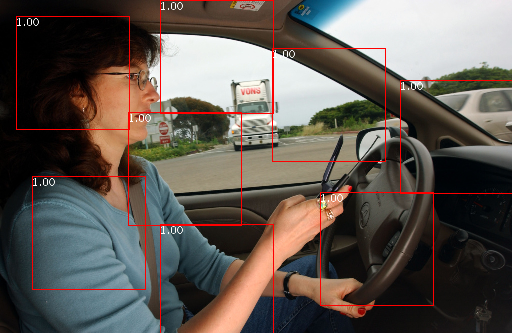

In [266]:
img.resize((int(img.size[0]/2), int(img.size[1]/2)))

In [313]:
img.crop((1250, 230, 1450, 400)).resize((227,227)).save('tmp.jpg')

In [241]:
img.crop(np.array(true_boxes[1][:4], dtype=np.int)).save('tmp.jpg')

In [314]:
im = caffe.io.load_image("tmp.jpg")
transformer = caffe.io.Transformer({'data': net_full.blobs['data'].data.shape})
transformer.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1))
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)

In [315]:
out = net_full.forward_all(data=np.asarray([transformer.preprocess('data', im)]))

In [316]:
out

{'prob': array([[ 0.05150549,  0.94849455]], dtype=float32)}

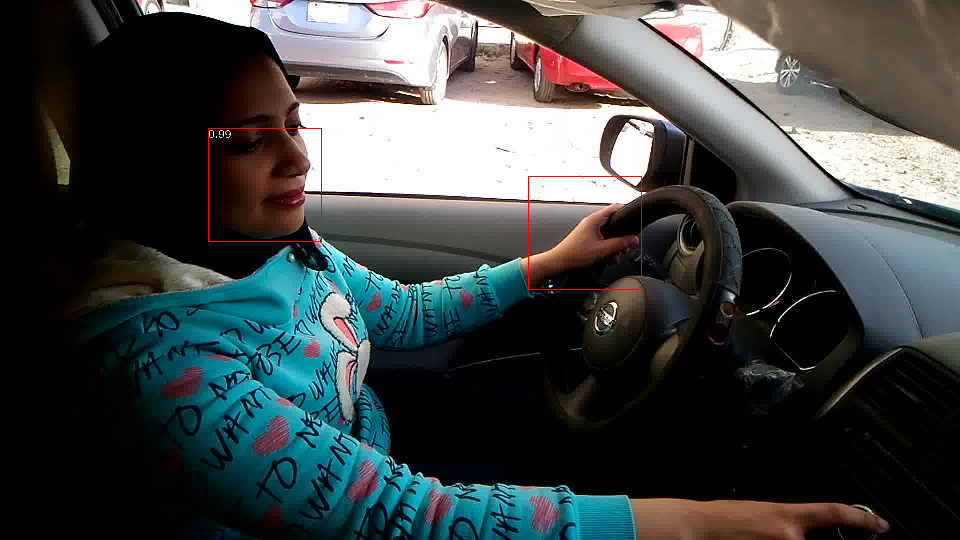

In [183]:
img.resize((int(img.size[0]/2), int(img.size[1]/2)))

In [145]:
img.crop(box=(1000, 375, 1300,575)).resize((227, 227)).save('tmp.jpg')

In [151]:
def convert_full_conv():
    # Load the original network and extract the fully connected layers' parameters.
    net = caffe.Net('/home/devyhia/LendingAHand/hand_classifier.prototxt',
                    '/home/devyhia/LendingAHand/hand_classifier.caffemodel',
                    caffe.TEST)
    params = ['fc6', 'fc7', 'fc8_flickr']
    fc_params = {pr: (net.params[pr][0].data, net.params[pr][1].data) for pr in params}
    # Load the fully convolutional network to transplant the parameters.
    net_full_conv = caffe.Net('/home/devyhia/LendingAHand/hand_classifier_conv.prototxt',
                              '/home/devyhia/LendingAHand/hand_classifier.caffemodel',
                              caffe.TEST)
    params_full_conv = ['fc6-conv', 'fc7-conv', 'fc8-conv']
    conv_params = {pr: (net_full_conv.params[pr][0].data, net_full_conv.params[pr][1].data) for pr in params_full_conv}
    for pr, pr_conv in zip(params, params_full_conv):
        conv_params[pr_conv][0].flat = fc_params[pr][0].flat  # flat unrolls the arrays
        conv_params[pr_conv][1][...] = fc_params[pr][1]
    net_full_conv.save('/home/devyhia/LendingAHand/hand_classifier_conv.caffemodel')

In [152]:
convert_full_conv()

In [318]:
!pip install selectivesearch --user

  Running setup.py bdist_wheel for selectivesearch ... - done
  Stored in directory: /home/devyhia/.cache/pip/wheels/fe/a7/2c/5e52caa60318bbdfdfb22f18e5879e12c8c3dc355b81ff20fb
Successfully built selectivesearch
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [13]:
import selectivesearch

In [14]:
img_lbl, regions = selectivesearch.selective_search(img_arr, scale=0.25, sigma=0.9, min_size=10)

In [25]:
regions_dict = {}
for r in regions:
    regions_dict[r['rect']] = r

In [28]:
regions = []
for k in regions_dict:
    regions.append(regions_dict[k])

In [21]:
draw = ImageDraw.Draw(img)
for r in sorted([ r for r in regions if r['size'] < 0.5*1920*1080], reverse=True, key=lambda r: r['prob'])[:10]:
    box = r['rect']
    prob = r['prob']
    draw.rectangle(box, outline=(255,0,0))
    font_path=os.environ.get("FONT_PATH", "/usr/share/fonts/truetype/dejavu/DejaVuSerif.ttf")
    ttFont = ImageFont.truetype(font_path, 20)
    draw.text((box[0], box[1]), "{0:.2f}".format(prob), font=ttFont)

In [40]:
sorted(regions, reverse=True, key=lambda r: r['prob'])[:5]

[{'labels': [541.0,
   543.0,
   548.0,
   547.0,
   546.0,
   0.0,
   1089.0,
   793.0,
   799.0,
   1092.0,
   1101.0,
   1075.0,
   1078.0,
   553.0,
   555.0,
   558.0,
   757.0,
   768.0,
   756.0,
   804.0,
   773.0,
   763.0,
   759.0,
   762.0,
   764.0,
   772.0,
   760.0,
   761.0,
   783.0,
   784.0,
   769.0,
   774.0,
   758.0,
   765.0,
   770.0,
   589.0,
   72.0,
   76.0,
   71.0,
   77.0,
   78.0,
   81.0,
   698.0,
   699.0,
   645.0,
   115.0,
   117.0,
   116.0,
   196.0,
   198.0,
   967.0,
   969.0,
   1005.0,
   1009.0,
   1006.0,
   441.0,
   980.0,
   997.0,
   983.0,
   975.0,
   113.0,
   1000.0,
   971.0,
   970.0,
   979.0,
   1033.0,
   960.0,
   1012.0,
   1047.0,
   978.0,
   1045.0,
   981.0,
   1016.0,
   444.0,
   1011.0,
   1002.0,
   1003.0,
   1004.0,
   1008.0,
   976.0,
   1043.0,
   1084.0,
   984.0,
   999.0,
   996.0,
   985.0,
   1001.0,
   1007.0,
   1046.0,
   1044.0,
   982.0,
   111.0,
   112.0,
   961.0,
   968.0,
   443.0,
   1030.0,
  

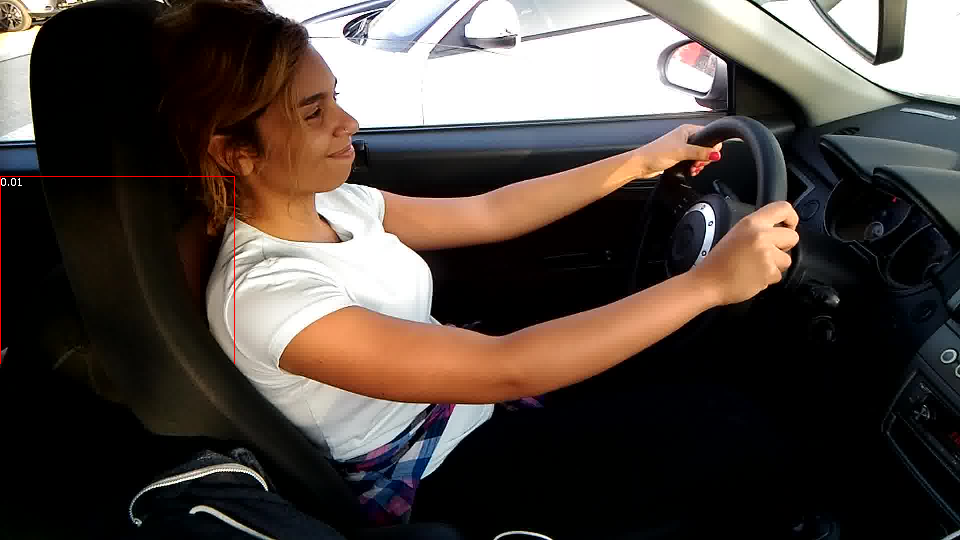

In [22]:
img.resize((int(img.size[0]/2), int(img.size[1]/2)))